In [1]:
import tensorflow as tf
import numpy as np
import math
na = np.newaxis
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

# import helper functions from utils.py:
from utils import build_2d_grid, train_parameters, evaluation, tf_tril_indices, load_lookup_table, table_lookup_op_parallel, get_scp_samples, build_graph, build_eval_graph, get_test_log_likelihood


# Planning:

- test on simple example and compare real / optimized distributions (define real dist-> sample data -> calc approx -> compare)
- test on real dataset

### BUGS:
- urgent: logdet calculation gives Nans, current fix: replace the zeros by eye in the sparse add, does not solve it in any case however

-> try: does it work with decomp and I stabilizer?

- m and S values go to infinity if inducing_point_res >= 9


### TODOS:
- lower bound >0 ???
- Check T region definition (currently limits of inducing points)
- calculate and print lower bound for testset
- improve 2d sampling function
- optimize Lookup Table resolution (Max)

# 2d example

In [2]:
from scipy.stats import multivariate_normal

def double_blob(x):
    blob_1 = multivariate_normal.pdf(x, mean = [3, 3], cov=[[1, 0], [0, 1]])
    blob_2 = multivariate_normal.pdf(x, mean = [7, 7], cov=[[1, 0], [0, 1]])
    return (blob_1 + blob_2) * 10

def gram_matrix(xs):
    return np.array([[ard_kernel(x1,x2) for x2 in xs] for x1 in xs])

def ard_kernel(x1,x2):
    R = 2
    a = np.ones([R])*5
    g = 0.7
    return g * np.prod([np.exp(-1 * ((x1-x2) ** 2) / (2 * a[r])) for r in range(R)])

def gaussian_process_rate_function(xs):
    mean = [0 for x in xs]
    gram = gram_matrix(xs)
    result = np.random.multivariate_normal(mean, gram)**2

    return result

In [3]:
upper_bound = 2
Tlims = np.array([[0., 10.], [0., 10.]])
res = 20

#generate samples
samples,test_samples, _,xx, yy,vals = get_scp_samples(gaussian_process_rate_function, Tlims, upper_bound,res)
                                                    

Input dimension is : 2
Volume is: 100.0


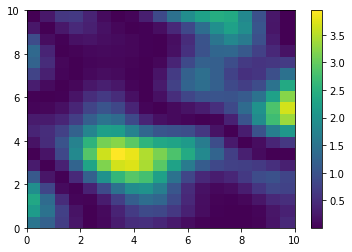

4.2814959262


In [4]:
#plot the rate_function over a grid
plot_vals = vals.reshape(res,res)
plt.pcolormesh(xx, yy, plot_vals.reshape(res,res))
plt.colorbar()
plt.show()

print(np.max(plot_vals))

72


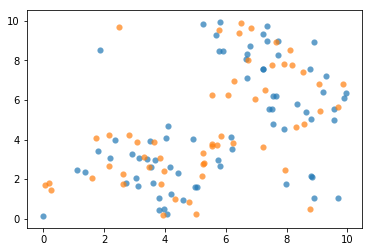

In [8]:
# sampled data:
plt.scatter(samples[:,0], samples[:,1], linewidth=0.1, alpha=.7)
plt.scatter(test_samples[:,0], test_samples[:,1], linewidth=0.1, alpha=.7)

print('Num_data_points: ', samples.shape[0])

plt.show()

# Variational Approximation

### 2D Parameter Learning

In [14]:
## ######## ##
# PARAMETERS #
## ######## ##

tf.logging.set_verbosity(tf.logging.DEBUG)

# general options
train_hyperparameters    = True
optimize_inducing_points = False
ind_point_nums           = [8]

# gradient descent optionss
max_iterations = 1000
learning_rate  = 0.001

# hyperparameter initialization:
alphas_init = [0.005,  0.005]
gamma_init  = 0.7

# tensorboard options:
logdir = 'logs/2d_example'

# build_evaluation_grid
eval_grid = build_2d_grid(Tlims, res)

for n_ind, i in enumerate(ind_point_nums): 
        
    m_opt, S_opt, Kzz_inv_opt, alphas_opt, Z_opt,gamma_opt = train_parameters(samples, i, Tlims, 
                                                                              optimize_inducing_points=optimize_inducing_points, 
                                                                              train_hyperparameters=train_hyperparameters,
                                                                              learning_rate=learning_rate,
                                                                              max_iterations=max_iterations,
                                                                              log_dir=logdir,
                                                                              alphas_init=alphas_init,
                                                                              gamma_init=gamma_init
                                                                             ) 

Begin training
Fixed inducing points on a grid
Z.shape: (64, 2)


InvalidArgumentError: Infinity in summary histogram for: expectation_at_datapoints/mu_and_sig_calculation/kernel_matrices_summaries/KXX
	 [[Node: expectation_at_datapoints/mu_and_sig_calculation/kernel_matrices_summaries/KXX = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](expectation_at_datapoints/mu_and_sig_calculation/kernel_matrices_summaries/KXX/tag, expectation_at_datapoints/mu_and_sig_calculation/K_XX/ard_kernel/mul_1)]]

Caused by op 'expectation_at_datapoints/mu_and_sig_calculation/kernel_matrices_summaries/KXX', defined at:
  File "/usr/lib/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.4/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/lea/tensorflowPy3/lib/python3.4/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.4/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.4/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.4/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/lea/tensorflowPy3/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/lea/tensorflowPy3/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/lea/tensorflowPy3/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-3523fa4cca98>", line 35, in <module>
    gamma_init=gamma_init
  File "/home/lea/Schreibtisch/TUB/WS17/KI-Projekt/pmai-vi-gpmpp/utils.py", line 47, in train_parameters
    lower_bound, merged, Z_ph, u_ph, X_ph, m, S,L_vech, interesting_gradient, K_zz_inv, alphas, gamma, Kzz, omegas, covariance_asserts = build_graph(Tlims, num_inducing_points, D, alphas_init, gamma_init, m_init_val, lvech_init_stddev, optimize_inducing_points, assert_correct_covariances=False)
  File "/home/lea/Schreibtisch/TUB/WS17/KI-Projekt/pmai-vi-gpmpp/utils.py", line 310, in build_graph
    mu_t, sig_t_sqr = mu_tilde_square(X_ph,Z_ph,S,m,K_zz_inv, alphas, gamma)
  File "/home/lea/Schreibtisch/TUB/WS17/KI-Projekt/pmai-vi-gpmpp/utils.py", line 398, in mu_tilde_square
    tf.summary.histogram('KXX', K_xx)
  File "/home/lea/tensorflowPy3/lib/python3.4/site-packages/tensorflow/python/summary/summary.py", line 192, in histogram
    tag=tag, values=values, name=scope)
  File "/home/lea/tensorflowPy3/lib/python3.4/site-packages/tensorflow/python/ops/gen_logging_ops.py", line 188, in _histogram_summary
    "HistogramSummary", tag=tag, values=values, name=name)
  File "/home/lea/tensorflowPy3/lib/python3.4/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/lea/tensorflowPy3/lib/python3.4/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/lea/tensorflowPy3/lib/python3.4/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Infinity in summary histogram for: expectation_at_datapoints/mu_and_sig_calculation/kernel_matrices_summaries/KXX
	 [[Node: expectation_at_datapoints/mu_and_sig_calculation/kernel_matrices_summaries/KXX = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](expectation_at_datapoints/mu_and_sig_calculation/kernel_matrices_summaries/KXX/tag, expectation_at_datapoints/mu_and_sig_calculation/K_XX/ard_kernel/mul_1)]]


ind point number:  7
alphas:  [ 2.43672991  2.30477071]
gamma:  0.475198


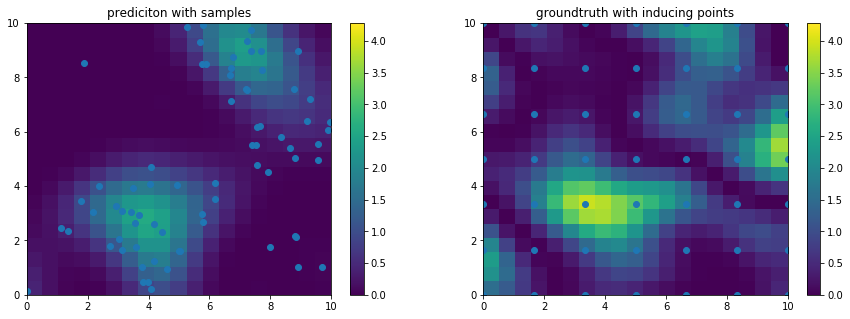

In [12]:
lam_vals,lam_var = evaluation(m_opt,S_opt,Kzz_inv_opt,alphas_opt,gamma_opt,Z_opt, eval_grid)

#plots
fig = plt.figure(figsize=(15, 5)) 
max_value = np.max([np.max(vals), np.max(lam_vals)])
norm = mpl.colors.Normalize(vmin=0, vmax=max_value)

print("ind point number: ",i)
print("alphas: ",alphas_opt)
print("gamma: ",gamma_opt)
    
xx, yy = np.meshgrid(np.linspace(Tlims[0,0], Tlims[0,1], res), np.linspace(Tlims[1,0], Tlims[1,1], res))
    
ax0 = plt.subplot(1,2,1)
im = ax0.pcolormesh(xx, yy, lam_vals.reshape(res,res),  norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('prediciton with samples')
ax0.scatter(samples[:,0], samples[:,1])
plt.xlim(Tlims[0,0], Tlims[0,1])
plt.ylim(Tlims[1,0], Tlims[1,1])

ax1 = plt.subplot(1,2, 2)
im1 = ax1.pcolormesh(xx, yy, plot_vals, norm=norm)
fig.colorbar(im1, ax=ax1)
ax1.set_title('groundtruth with inducing points')
ax1.scatter(Z_opt[:, 0], Z_opt[:,1])
plt.xlim(Tlims[0,0], Tlims[0,1])
plt.ylim(Tlims[1,0], Tlims[1,1])
#plt.savefig('results/' + run_prefix + '_result.png', dpi=300)
plt.show()

In [ ]:
def get_lower_test_bound(test_samples, m, S, Kzz_inv, a, g, Z):
    lower_bound, Z_ph, X_test_ph, m_ph, S_ph,K_zz_inv_ph,a_ph,g_ph  = get_test_log_likelihood()

    #run session
    with tf.Session() as sess:
        lower_bound_val, = sess.run([lower_bound], feed_dict={Z_ph:Z, X_test_ph:test_samples,K_zz_inv_ph: Kzz_inv,S_ph:S,m_ph:m,a_ph:a,g_ph:g})

    return lower_bound_val
